
# Movie Recommendation System

This notebook builds a content-based movie recommender using the MovieLens dataset. It uses:
- TF-IDF for genres
- Average ratings
- Cosine similarity
- PCA and KMeans for clustering
- A Streamlit interface for recommendations

---

## 1. Import Libraries and Load Data


In [15]:
#Import Libraries
import pandas as pd
import numpy as np
import streamlit as st
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

st.title("🎬 Movie Recommender System")

st.write("Dataset loaded successfully!")


## 2. EDA

In [3]:
# Display basic info
print("Movies Data Info:")
print(movies.info())

print("\nRatings Data Info:")
print(ratings.info())

Movies Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None

Ratings Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB
None


In [4]:
# Display statistics
print("\nMovies Data Description:")
print(movies.describe(include='all'))

print("\nRatings Data Description:")
print(ratings.describe())


Movies Data Description:
              movieId                     title genres
count    10329.000000                     10329  10329
unique            NaN                     10327    938
top               NaN  War of the Worlds (2005)  Drama
freq              NaN                         2   1385
mean     31924.282893                       NaN    NaN
std      37734.741149                       NaN    NaN
min          1.000000                       NaN    NaN
25%       3240.000000                       NaN    NaN
50%       7088.000000                       NaN    NaN
75%      59900.000000                       NaN    NaN
max     149532.000000                       NaN    NaN

Ratings Data Description:
              userId        movieId         rating     timestamp
count  105339.000000  105339.000000  105339.000000  1.053390e+05
mean      364.924539   13381.312477       3.516850  1.130424e+09
std       197.486905   26170.456869       1.044872  1.802660e+08
min         1.000000       

In [5]:
# Check nulls
print("\nMissing values in movies:")
print(movies.isnull().sum())

print("\nMissing values in ratings:")
print(ratings.isnull().sum())


Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


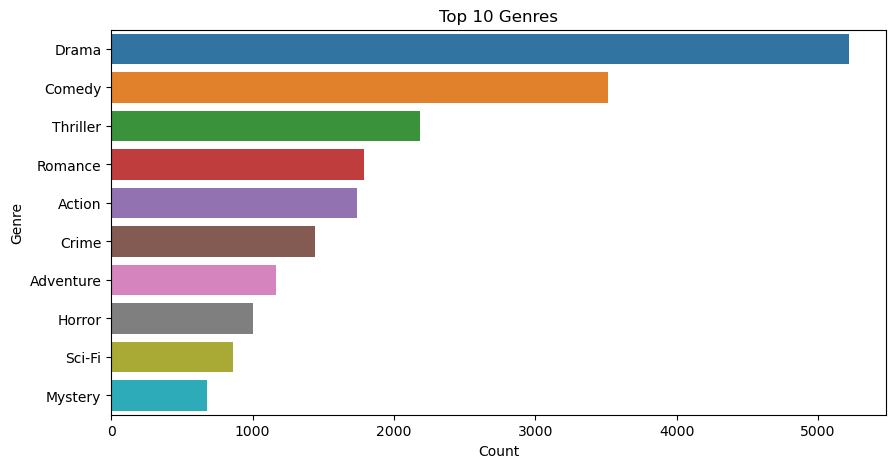

In [6]:
# Most common genres
all_genres = movies['genres'].str.split('|').explode()
plt.figure(figsize=(10, 5))
sns.countplot(y=all_genres, order=all_genres.value_counts().index[:10])
plt.title("Top 10 Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


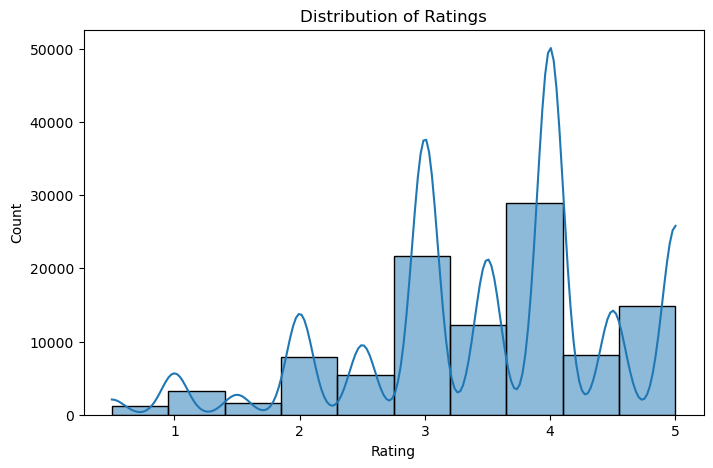

In [7]:
# Ratings distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Exploring Movie Genres and Ratings

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


DeltaGenerator()

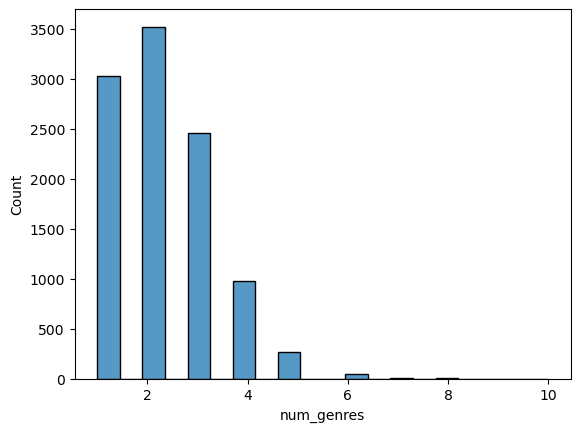

In [8]:
# Preprocess genres
movies['genres'] = movies['genres'].str.replace('|', ' ')
movies['num_genres'] = movies['genres'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# Display genre distribution plot
st.subheader("Distribution of Number of Genres")
fig, ax = plt.subplots()
sns.histplot(movies['num_genres'], bins=20, ax=ax)
st.pyplot(fig)

# Top genres
from collections import Counter
all_genres = ' '.join(movies['genres'].dropna()).split()
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values('Count', ascending=False)

st.subheader("Top Genres")
st.dataframe(genre_df.head(10))


## 3. Feature Extraction from Genres + Ratings

In [9]:

# TF-IDF on genres
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(''))

# Average rating
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.columns = ['movieId', 'avg_rating']
movies = movies.merge(avg_ratings, on='movieId', how='left')

# Combine features
features = np.hstack((tfidf_matrix.toarray(), movies[['avg_rating']].fillna(0).values))

# Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


## 4. Clustering Movies using KMeans + PCA

In [10]:

# PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

# KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

movies['Cluster'] = clusters

# Plot
st.subheader("PCA Clustering Plot")
fig2, ax2 = plt.subplots()
scatter = ax2.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='tab10')
plt.colorbar(scatter)
st.pyplot(fig2)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DeltaGenerator()

## 5. Streamlit Recommender Interface

In [11]:

# Similarity matrix
cos_sim = cosine_similarity(tfidf_matrix)

# Build simple recommender
movie_titles = movies['title'].tolist()
selected_movie = st.selectbox("Select a movie to get recommendations:", movie_titles)

if selected_movie:
    index = movies[movies['title'] == selected_movie].index[0]
    similarity_scores = list(enumerate(cos_sim[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_movies = [movie_titles[i[0]] for i in similarity_scores[1:6]]

    st.write("Top 5 Recommended Movies:")
    for i, title in enumerate(top_movies, 1):
        st.write(f"{i}. {title}")


In [12]:
st.subheader("🎯 Was this recommendation helpful?")
feedback = st.radio("Your feedback:", ["👍 Yes", "👎 No"])

if st.button("Submit Feedback"):
    import datetime
    feedback_data = {
        "timestamp": datetime.datetime.now(),
        "feedback": feedback,
        # Optionally, add user_id or movie_id if available
    }

    import os
    import csv

    # Save feedback to a CSV file
    feedback_file = "user_feedback.csv"
    file_exists = os.path.isfile(feedback_file)

    with open(feedback_file, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=feedback_data.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(feedback_data)

    st.success("Thank you for your feedback! 🎉")


### Technical Report

- **Data**: Used MovieLens dataset (`movies.csv`, `ratings.csv`)
- **EDA**: Analyzed genre distributions and identified popular genres.
- **Feature Engineering**: Extracted genre-based TF-IDF features and average movie ratings.
- **Clustering**: Applied K-Means and visualized with PCA.
- **Similarity**: Used cosine similarity for recommendations.
- **Interface**: Built a Streamlit-based interactive web tool.

**Movie Recommendation System**

**1. Objective**  
Build a content-based movie recommender using MovieLens data with clustering & similarity.

**2. Dataset**  
- Source: Kaggle (MovieLens)  
- Files: `movies.csv`, `ratings.csv`

**3. EDA**  
- Checked nulls  
- Plots: rating dist., top genres, genre count/movie

**4. Feature Engineering**  
- TF-IDF on genres  
- Avg. movie ratings  
- Combined TF-IDF + ratings

**5. Clustering**  
- Scaled features  
- PCA (2D)  
- K-Means (10 clusters)  
- Cluster visualization

**6. Recommendations**  
- Cosine similarity (TF-IDF)  
- Input movie → Top 5 similar movies

**7. Interface (Streamlit)**  
- Dropdown for movie  
- Plots & top 5 recommendations

**8. Limitations**  
- No user profiles or tags  
- No NLP on descriptions

**9. Tech Stack**  
Python, Pandas, NumPy, Sklearn, Streamlit, Matplotlib, Seaborn
